In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import tf_data
import tensorflow as tf
from plotting import * 
from model import *
from plotting import * 

In [4]:
model = tf.keras.models.load_model("/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v4/run_08/model")

AttributeError: 'RaggedTensorSpec' object has no attribute 'shape'

In [3]:
import mplhep as hep
plt.style.use(hep.style.CMS)

In [5]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/testing/calo_matched/*.proto",
             #"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v6/testing/no_calo_matched/*.proto",
             #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [6]:
features = [ "en_cluster","et_cluster", 
            "cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
            "cl_sigmaIphiIphi","cl_swissCross",
            "cl_nxtals", "cl_etaWidth","cl_phiWidth"]


metadata =  [  "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
            "nclusters_insc","max_en_cluster_insc","max_deta_cluster_insc",
            "max_dphi_cluster_insc",
             "max_en_cluster","max_deta_cluster","max_dphi_cluster",
            "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ]

In [14]:
test_ds = tf_data.load_balanced_dataset_batch(data_path, features, metadata, 1, filter= lambda d1,d2: d1["n_cl"]> 15)
# the indexes for energy and et are from the features list we requestes
test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization.npz")
test_ds = tf_data.training_format(test_ds)


In [104]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
total_ds = tf_data.load_dataset_single(data_path["ele_match"],{"read_hits":True, "read_metadata":True}).shuffle(1000)

# total_ds = total_ds.filter(lambda d1,d2:   d1["s_f"][0]>2.4 and  d1["w_m"][10]==6 and d1["n_cl"]> 5)
# total_ds = total_ds.filter(lambda d1,d2:   d1["w_m"][10]>3 and d1["n_cl"]> 15)
total_ds = total_ds.filter(lambda d1,d2:    d1["n_cl"]> 15)

In [9]:
it = iter(test_ds.take(10))

In [10]:
df = next(it)

In [15]:
def delta_iphi(phi1, phi2):
    dphi = phi1 - phi2
    mask_1 = dphi > 180
    mask_2 = dphi < 180
    dphi =  dphi - mask_1 * 2*180
    return dphi

import math
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    mask_1 = dphi > math.pi
    mask_2 = dphi < math.pi
    dphi =  dphi - mask_1 * math.pi
    return dphi


def delta_eta(ieta_seed, ieta):
    if (ieta_seed >0):
        return ieta - ieta_seed
    else:
        return ieta_seed - ieta
    return deta

In [117]:
cl_f = df[1]["cl_f"].numpy()
seed_f = df[0]["s_f"].numpy()

seed_eta = df[0]["s_f"][0]
fl = df[0]["f"].numpy()

deta = cl_f[:,3]
dphi =  cl_f[:,4]

ncl = df[0]["n_cl"]

dphi_range = np.max(np.abs(dphi))
deta_range = np.max(np.abs(deta))

cl_et = cl_f[:,6]

et_size = cl_et*20

in_sc = df[1]["cl_l"][:,3].numpy()
in_mustache = df[1]["cl_l"][:,4].numpy()

colors_insc = list(map(lambda a:  "#16ab3e" if a else "#f2422e" , in_sc))
colors_inmust = list(map(lambda a:  "#422ef2" if a else "#f2422e" , in_mustache))

cl_simen_pu = df[1]["cl_m"][:,2]
cl_simen_sig = df[1]["cl_m"][:,1]
cl_simscore = df[1]["cl_m"][:,0]
cl_simen_pu_frac = df[1]["cl_m"][:,3]

wdeta_up, wdeta_do, wdphi = dynamic_window(seed_eta) 

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

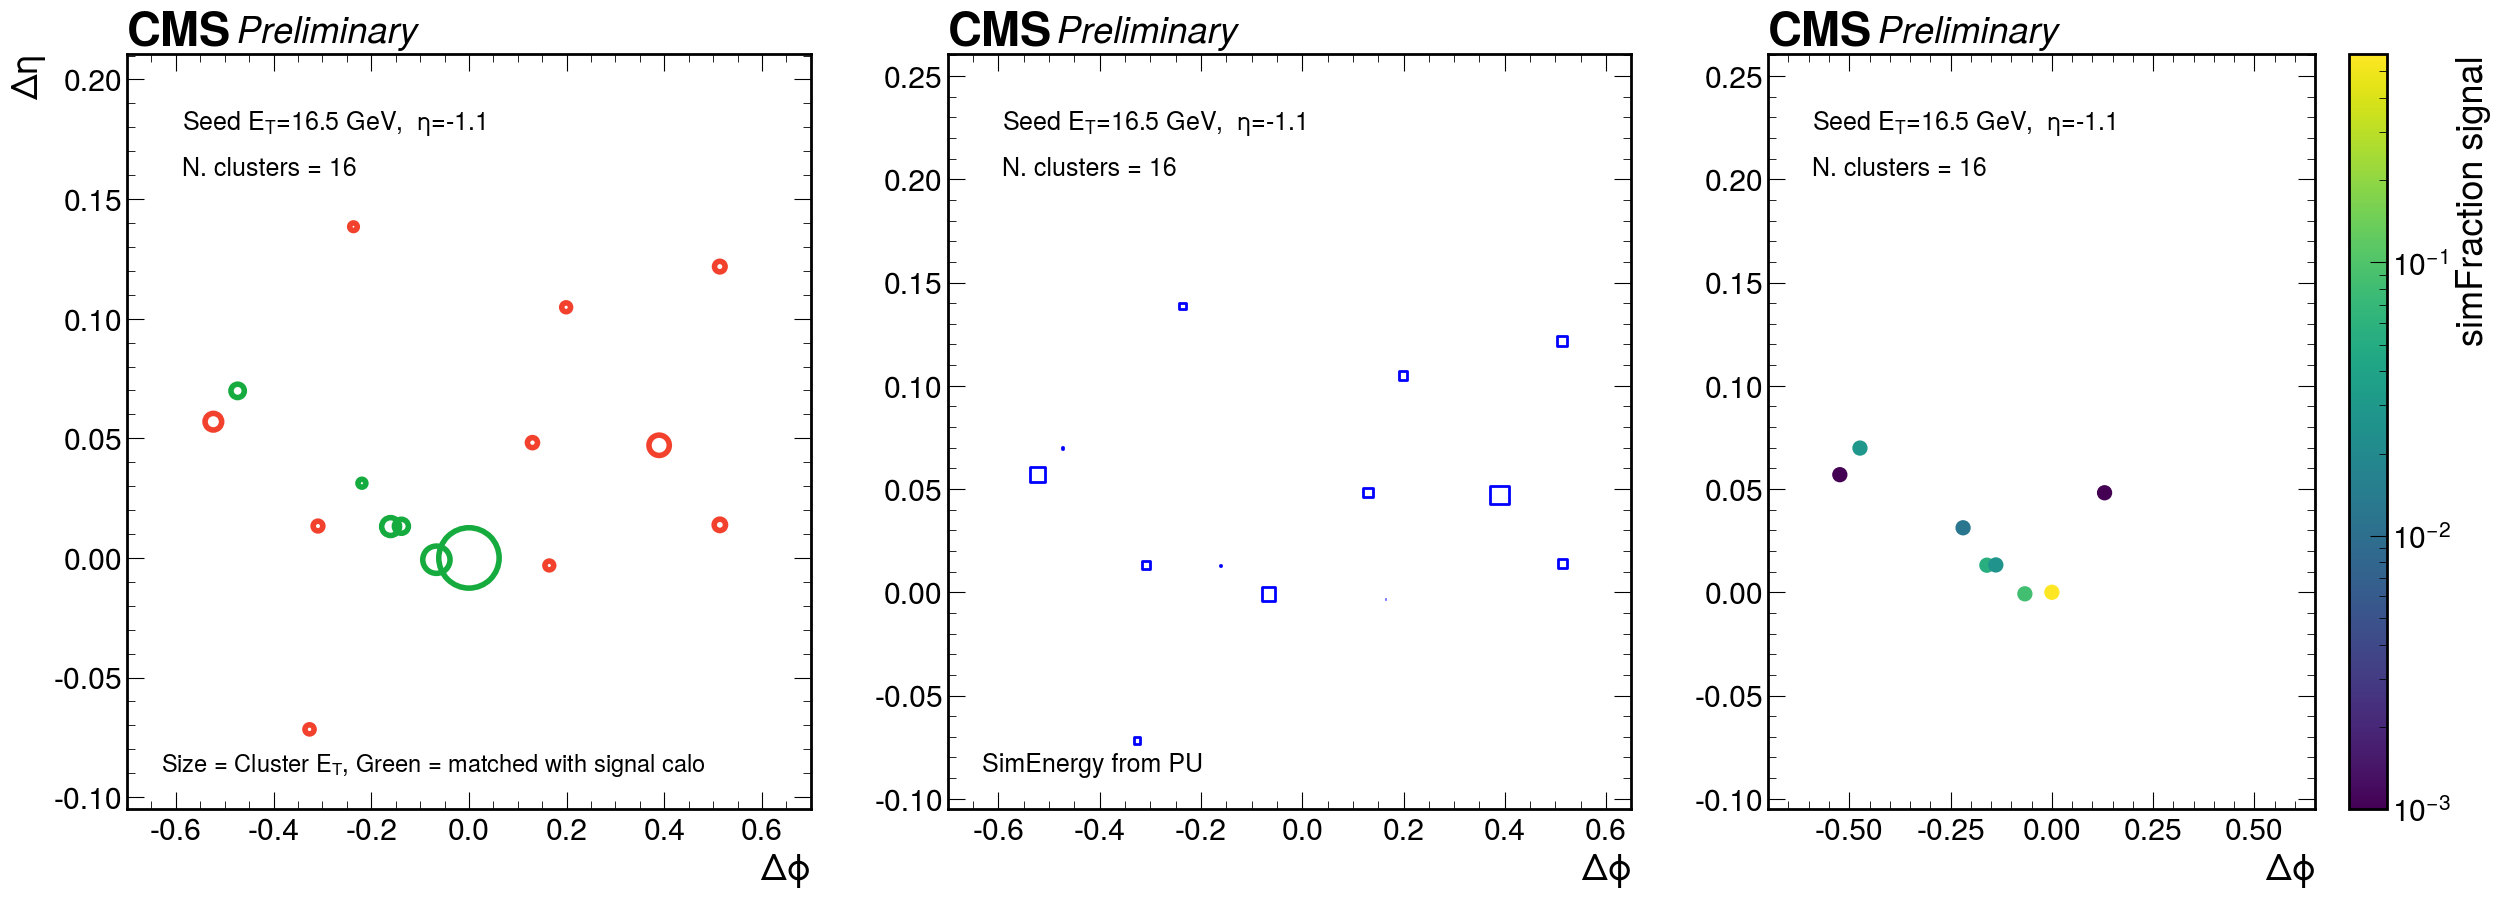

In [126]:
f, (ax1,  ax3, ax4) = plt.subplots(1,3,dpi=100, figsize=(30,10))
# ax1.set_aspect(4)
# ax3.set_aspect(4)
# ax4.set_aspect(4)
    
scatter = ax1.scatter(dphi,deta,  s=et_size*10,  marker="o", facecolors='none', edgecolors=colors_insc, linewidth=4)
ax1.set_xlim(-wdphi -0.1, wdphi + 0.1)
ax1.set_ylim(wdeta_do -0.03, wdeta_up + 0.05)
ax1.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax1.transAxes,)
ax1.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax1.transAxes,)
ax1.text(0.05, 0.05,"Size = Cluster $E_T$, Green = matched with signal calo", fontsize=17, transform=ax1.transAxes,)
ax1.set_xlabel("$\Delta\phi$")
ax1.set_ylabel("$\Delta\eta$")
# plt.colorbar(a, ax=ax1, label="Cluster energy [GeV]")
hep.cms.text("Preliminary ",loc=0, ax=ax1)


# scatter = ax2.scatter(dphi,deta,  s=100, c=colors_insc)
# ax2.set_xlim(-wdphi -0.1, wdphi + 0.1)
# ax2.set_ylim(wdeta_do -0.03, wdeta_up + 0.05)
# ax2.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax2.transAxes,)
# ax2.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax2.transAxes,)
# ax2.text(0.6, 0.84,"In SuperCluster", fontsize=20, transform=ax2.transAxes,)
# ax2.set_xlabel("$\Delta\phi$")
# # ax2.set_ylabel("$\Delta\eta$")
# # plt.colorbar(a, ax=ax1, label="Cluster energy [GeV]")
# hep.cms.text("Preliminary ",loc=0, ax=ax2)



a = ax3.scatter(dphi,deta, s=cl_simen_pu*100, marker="s", facecolors='none',  edgecolors='b', linewidth=2)
ax3.set_xlim(-wdphi -0.1, wdphi + 0.05)
ax3.set_ylim(wdeta_do -0.03, wdeta_up + 0.1)
ax3.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax3.transAxes,)
ax3.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax3.transAxes,)
ax3.text(0.05, 0.05,"SimEnergy from PU", fontsize=18, transform=ax3.transAxes,)
ax3.set_xlabel("$\Delta\phi$")
# ax4.set_ylabel("$\Delta\eta$")
# legend1 = ax3.legend(*a.legend_elements("sizes", num=4),
#                     title="A",  bbox_to_anchor=(0.6, 0.9,0.01,0.01))
# ax3.add_artist(legend1)

hep.cms.text("Preliminary ",loc=0, ax=ax3)


b = ax4.scatter(dphi,deta, c=cl_simscore, s=100, cmap="viridis", norm=colors.LogNorm(vmin=1e-3))
ax4.set_xlim(-wdphi -0.1, wdphi + 0.05)
ax4.set_ylim(wdeta_do -0.03, wdeta_up + 0.1)
ax4.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax4.transAxes,)
ax4.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax4.transAxes,)
ax4.set_xlabel("$\Delta\phi$")
# ax3.set_ylabel("$\Delta\eta$")
plt.colorbar(b, ax=ax4, label="simFraction signal",)
hep.cms.text("Preliminary ",loc=0, ax=ax4)


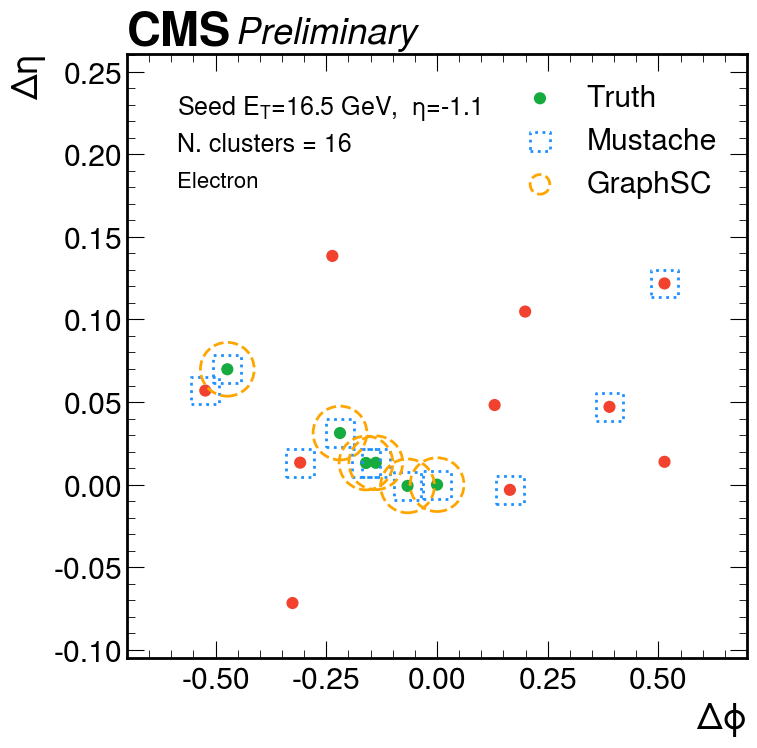

In [125]:
dphi_inmust = np.ma.masked_where(in_mustache==0, dphi)
deta_inmust = np.ma.masked_where(in_mustache==0, deta)
dphi_insc = np.ma.masked_where(in_sc==0, dphi)
deta_insc = np.ma.masked_where(in_sc==0, deta)

f, ax1 = plt.subplots(1,1,dpi=100, figsize=(8,8))

scatter = ax1.scatter(dphi,deta,  s=60,  marker="o", c=colors_insc, label="Truth")
ax1.set_xlim(-wdphi -0.1, wdphi + 0.1)
ax1.set_ylim(wdeta_do -0.03, wdeta_up + 0.1)
ax1.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax1.transAxes,)
ax1.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax1.transAxes,)
if fl ==11:
    ax1.text(0.08, 0.78,"Electron", fontsize=16, transform=ax1.transAxes,)
elif fl == 22:
    ax1.text(0.08, 0.78,"Photon", fontsize=16, transform=ax1.transAxes,)
else:
    ax1.text(0.08, 0.78,"PU", fontsize=16, transform=ax1.transAxes,)
    
# ax1.text(0.05, 0.05,"Size = Cluster $E_T$, Green = matched with signal calo", fontsize=17, transform=ax1.transAxes,)
ax1.set_xlabel("$\Delta\phi$")
ax1.set_ylabel("$\Delta\eta$")
# plt.colorbar(a, ax=ax1, label="Cluster energy [GeV]")
hep.cms.text("Preliminary ",loc=0, ax=ax1)

ax1.scatter(dphi_inmust,deta_inmust, s=400,  marker="s", linestyle="dotted", facecolors='none', edgecolors='dodgerblue', linewidth=2, label="Mustache")
ax1.scatter(dphi_insc,deta_insc, s=1500,  marker="o", linestyle="dashed",  facecolors='none', edgecolors='orange', linewidth=2, label="GraphSC")
# ax1.set_xlim(-wdphi -0.1, wdphi + 0.05)
# ax1.set_ylim(wdeta_do -0.03, wdeta_up + 0.1)
# ax1.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax5.transAxes,)
# ax1.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax5.transAxes,)
# ax1.set_xlabel("$\Delta\phi$")
# ax1.set_ylabel("$\Delta\eta$")

lgnd= plt.legend()

lgnd.legendHandles[1]._sizes = [200]
lgnd.legendHandles[2]._sizes = [200]

# hep.cms.text("Preliminary ",loc=0, ax=ax5)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

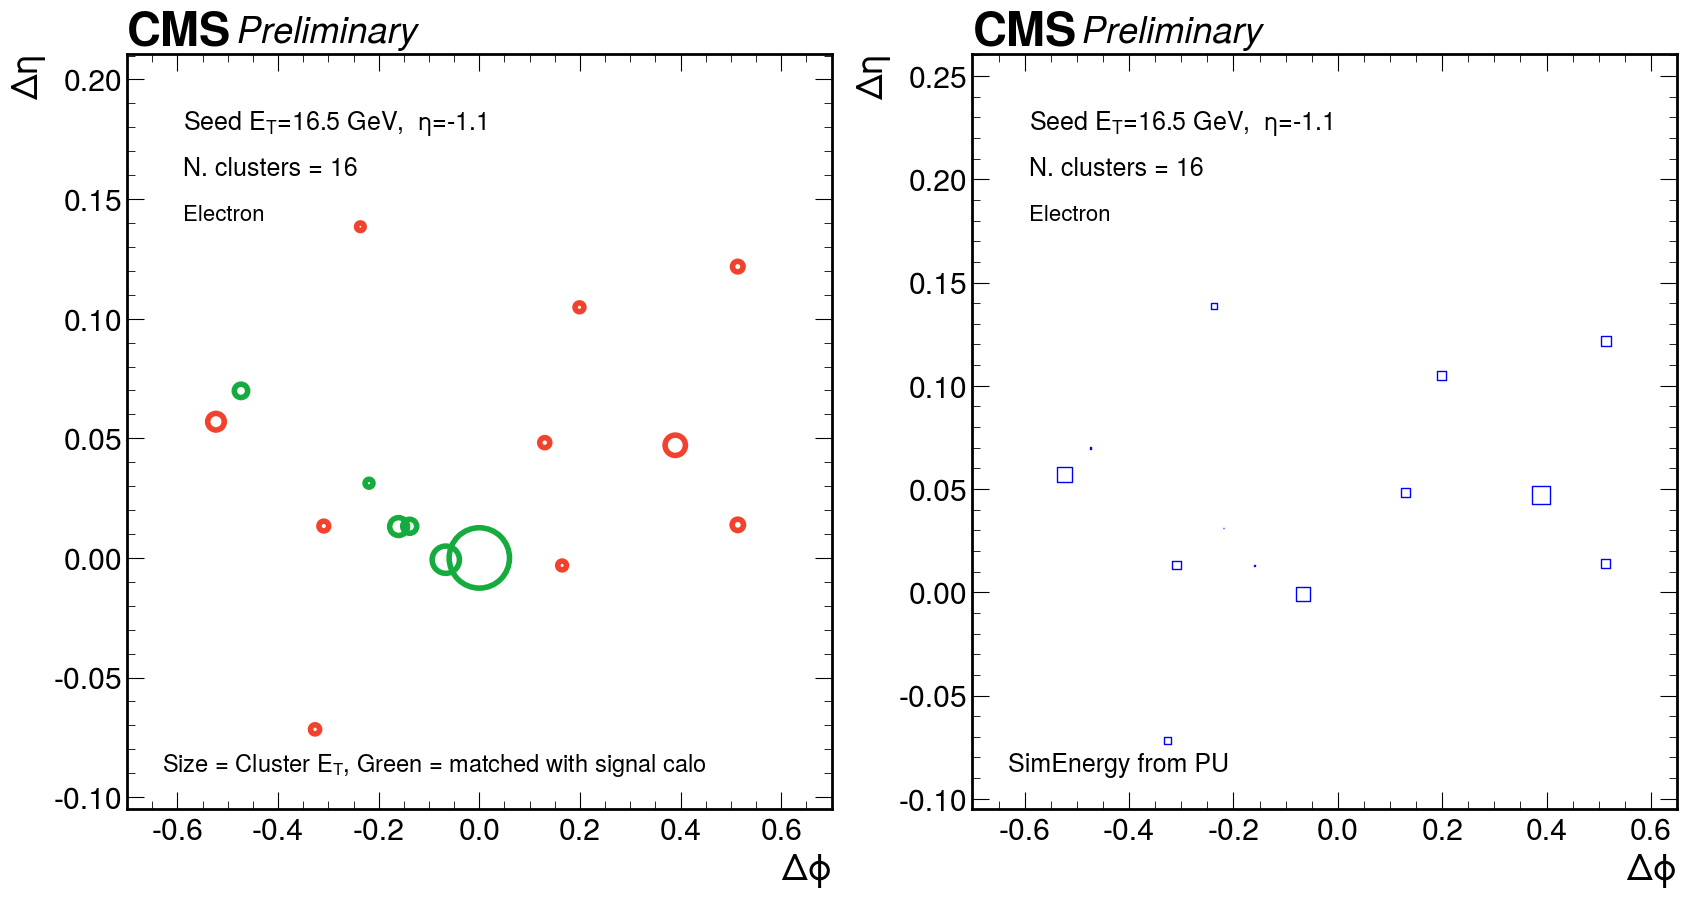

In [121]:
f, (ax1,  ax3) = plt.subplots(1,2,dpi=100, figsize=(20,10))
# ax1.set_aspect(4)
# ax3.set_aspect(4)
# ax4.set_aspect(4)
    
scatter = ax1.scatter(dphi,deta,  s=et_size*10,  marker="o", facecolors='none', edgecolors=colors_insc, linewidth=4)
ax1.set_xlim(-wdphi -0.1, wdphi + 0.1)
ax1.set_ylim(wdeta_do -0.03, wdeta_up + 0.05)
ax1.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax1.transAxes,)
ax1.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax1.transAxes,)
ax1.text(0.05, 0.05,"Size = Cluster $E_T$, Green = matched with signal calo", fontsize=17, transform=ax1.transAxes,)
if fl ==11:
    ax1.text(0.08, 0.78,"Electron", fontsize=16, transform=ax1.transAxes,)
elif fl == 22:
    ax1.text(0.08, 0.78,"Photon", fontsize=16, transform=ax1.transAxes,)
else:
    ax1.text(0.08, 0.78,"PU", fontsize=16, transform=ax1.transAxes,)
ax1.set_xlabel("$\Delta\phi$")
ax1.set_ylabel("$\Delta\eta$")
# plt.colorbar(a, ax=ax1, label="Cluster energy [GeV]")
hep.cms.text("Preliminary ",loc=0, ax=ax1)


# scatter = ax2.scatter(dphi,deta,  s=100, c=colors_insc)
# ax2.set_xlim(-wdphi -0.1, wdphi + 0.1)
# ax2.set_ylim(wdeta_do -0.03, wdeta_up + 0.05)
# ax2.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax2.transAxes,)
# ax2.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax2.transAxes,)
# ax2.text(0.6, 0.84,"In SuperCluster", fontsize=20, transform=ax2.transAxes,)
# ax2.set_xlabel("$\Delta\phi$")
# # ax2.set_ylabel("$\Delta\eta$")
# # plt.colorbar(a, ax=ax1, label="Cluster energy [GeV]")
# hep.cms.text("Preliminary ",loc=0, ax=ax2)



a = ax3.scatter(dphi,deta, s=cl_simen_pu*100, marker="s", facecolors='none',  edgecolors='b')
ax3.set_xlim(-wdphi -0.1, wdphi + 0.05)
ax3.set_ylim(wdeta_do -0.03, wdeta_up + 0.1)
ax3.text(0.08, 0.9,"Seed $E_T$={:.1f} GeV,  $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize=18, transform=ax3.transAxes,)
ax3.text(0.08, 0.84,"N. clusters = {}".format(ncl), fontsize=18, transform=ax3.transAxes,)
ax3.text(0.05, 0.05,"SimEnergy from PU", fontsize=18, transform=ax3.transAxes,)
if fl ==11:
    ax3.text(0.08, 0.78,"Electron", fontsize=16, transform=ax3.transAxes,)
elif fl == 22:
    ax3.text(0.08, 0.78,"Photon", fontsize=16, transform=ax3.transAxes,)
else:
    ax3.text(0.08, 0.78,"PU", fontsize=16, transform=ax3.transAxes,)
ax3.set_xlabel("$\Delta\phi$")
ax3.set_ylabel("$\Delta\eta$")
# legend1 = ax3.legend(*a.legend_elements("sizes", num=4),
#                     title="A",  bbox_to_anchor=(0.6, 0.9,0.01,0.01))
# ax3.add_artist(legend1)

hep.cms.text("Preliminary ",loc=0, ax=ax3)




NameError: name 'size' is not defined

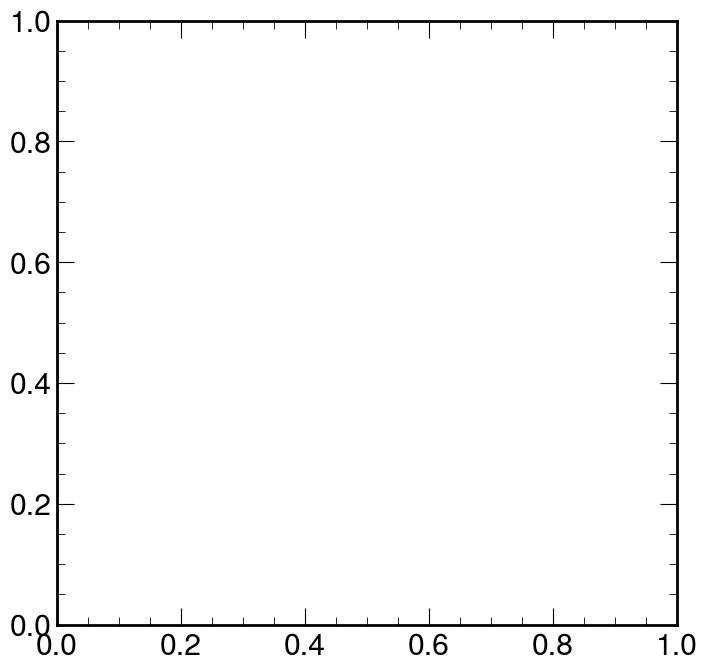

In [75]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(8,8))
scatter = ax.scatter(dphi,deta, s=size, c=colors_insc)
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.05 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
# legend1 = ax.legend(*scatter.legend_elements(),
#                     title="In supercluster",  bbox_to_anchor=(0.6, 0.9,0.01,0.01))
# ax.add_artist(legend1)

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

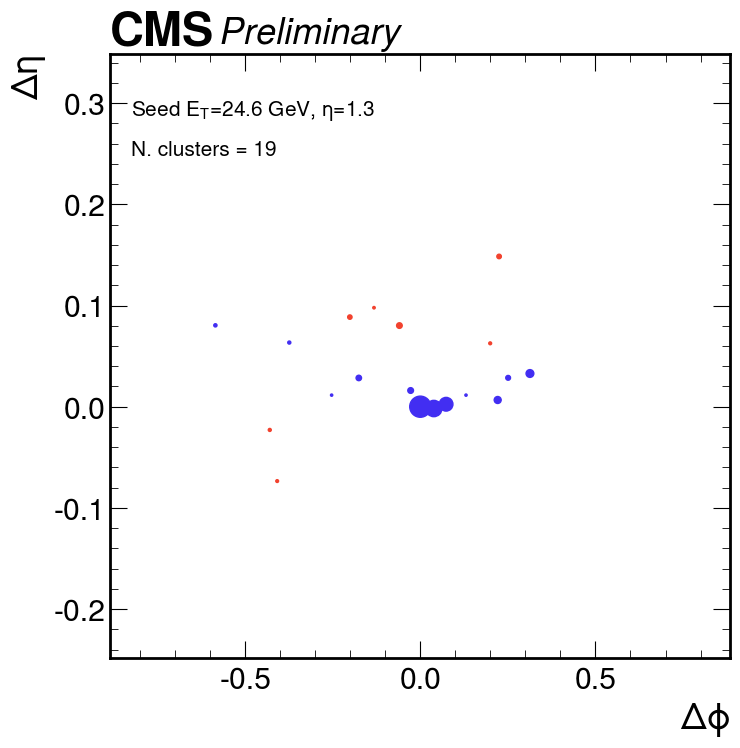

In [83]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(8,8))
ax.scatter(dphi,deta, s=size, c=colors_inmust)
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.1 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

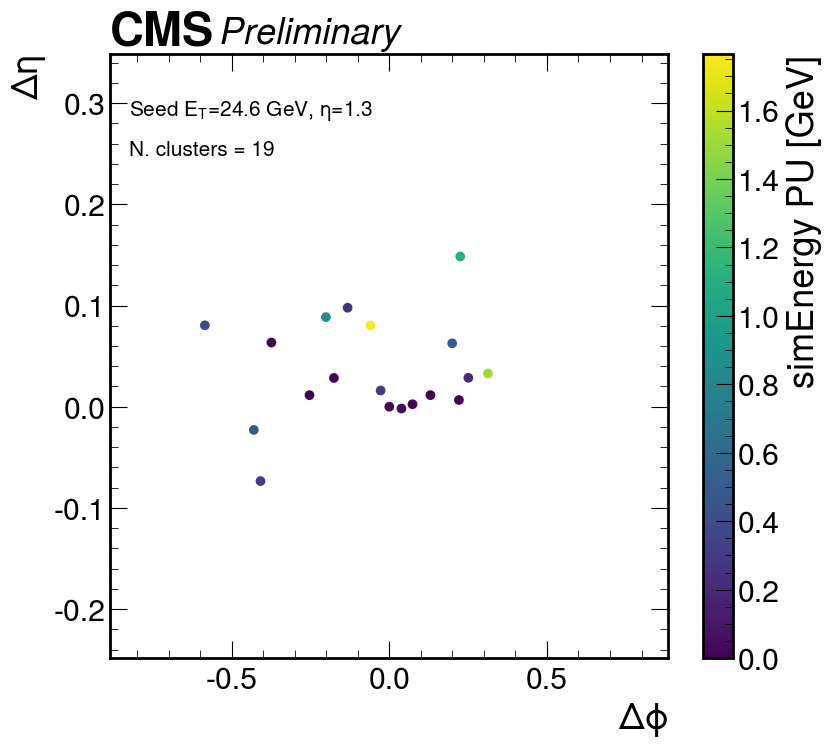

In [43]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(dphi,deta, c=cl_simen_pu)
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.1 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
plt.colorbar(a, ax=ax, label="simEnergy PU [GeV]")

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

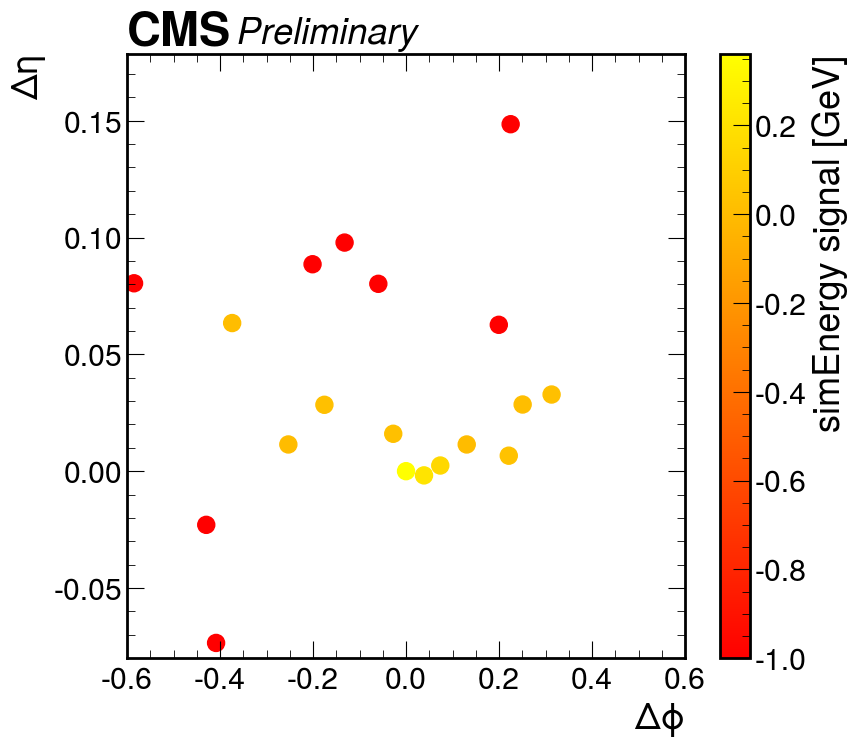

In [81]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(dphi,deta, c=cl_simscore,  cmap="autumn", s=150)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.08, deta_range+0.03)
# ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
# ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
plt.colorbar(a, ax=ax, label="simEnergy signal [GeV]")

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

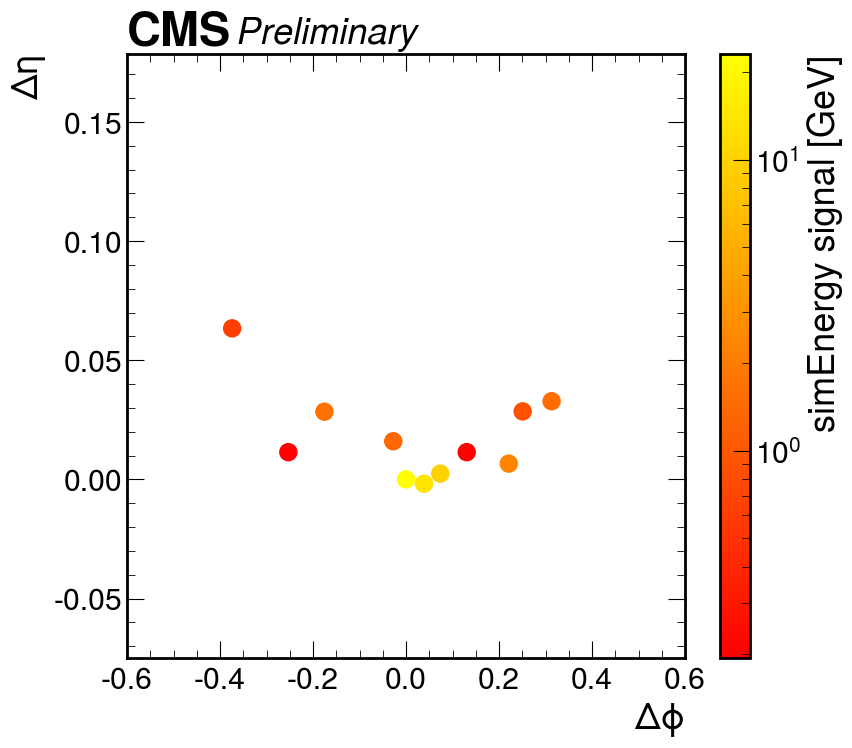

In [79]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(dphi,deta, c=cl_simen_sig, norm=colors.LogNorm(), cmap="autumn", s=150)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.075, deta_range+0.03)
# ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
# ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
plt.colorbar(a, ax=ax, label="simEnergy signal [GeV]")

hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

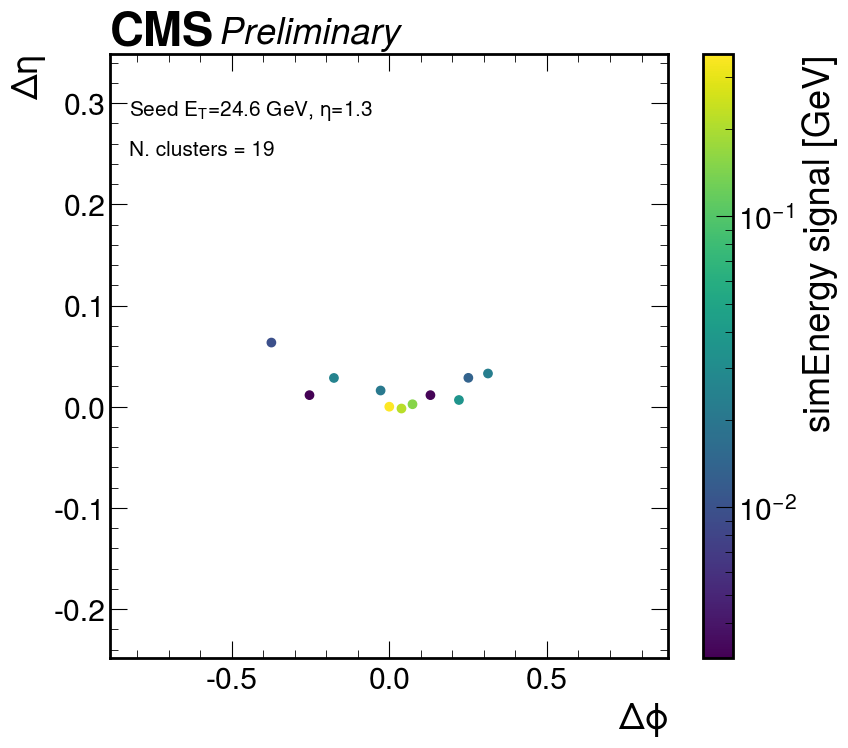

In [77]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(dphi,deta, c=cl_simscore, norm=colors.LogNorm())
ax.set_xlim(-dphi_range-0.3 , dphi_range+0.3)
ax.set_ylim(-deta_range-0.1 , deta_range+0.2)
ax.text(-dphi_range-0.24, +deta_range+0.14,"Seed $E_T$={:.1f} GeV, $\eta$={:.1f}".format(seed_f[7],seed_f[0]), fontsize="xx-small")
ax.text(-dphi_range-0.24, +deta_range+0.10,"N. clusters = {}".format(ncl), fontsize="xx-small")
ax.set_xlabel("$\Delta\phi$")
ax.set_ylabel("$\Delta\eta$")
plt.colorbar(a, ax=ax, label="simEnergy signal [GeV]")

hep.cms.text("Preliminary ",loc=0)

In [27]:
df[1]["cl_h"][:,:,1].flat_values

<tf.Tensor: shape=(31,), dtype=float32, numpy=
array([204., 205., 205., 204., 203., 202., 201., 201., 202., 203., 204.,
       205., 169., 169., 172., 196., 195., 214., 235., 203., 231., 230.,
       193., 237., 199., 228., 190., 227., 209., 189., 199.],
      dtype=float32)>

In [18]:
if seed_f[4] == 0  
 

SyntaxError: invalid syntax (<ipython-input-18-5a115fe54cc2>, line 1)

In [19]:
idphi = delta_iphi( seed_f[3], cl_f[:,1])
ideta = delta_eta(seed_f[2],cl_f[:,0])

rechit_en = df[1]["cl_h"][:,:,3].flat_values.numpy()
rechit_ieta = df[1]["cl_h"][:,:,0].flat_values.numpy()

if seed_f[2] < 0:
    rechit_ieta *= -1

rechit_iphi = delta_iphi(seed_f[3], df[1]["cl_h"][:,:,1].flat_values.numpy())

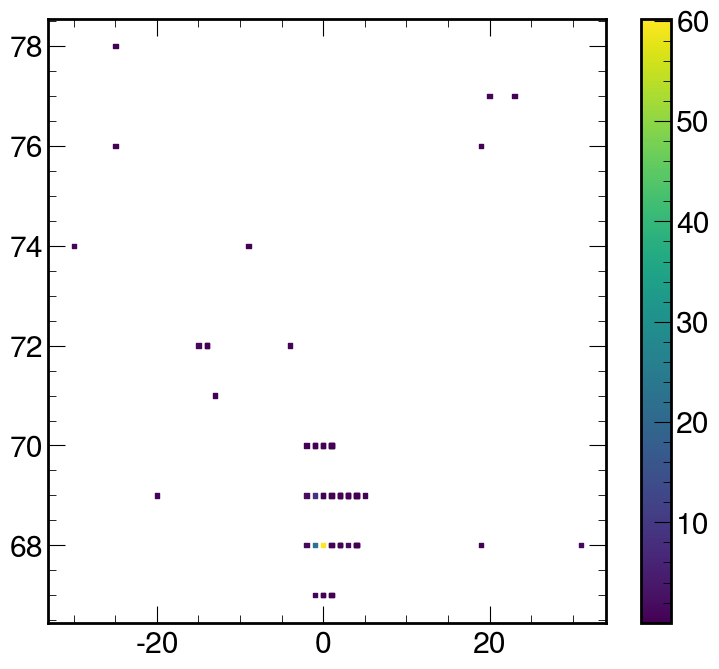

In [20]:
f, ax = plt.subplots(1,1,dpi=100, figsize=(9,8))
a = ax.scatter(rechit_iphi, rechit_ieta, c=rechit_en, marker="s", s=10)
plt.colorbar(a)

In [84]:
df[1]["cl_h"][:,:,3].shape

TensorShape([14, None])